In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

2024-12-17 13:16:00.427721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 13:16:00.584607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 13:16:00.584636: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 13:16:00.585297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 13:16:00.679499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 13:16:00.680412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
%matplotlib inline

In [3]:
CIFAR10_LABEL_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
def sample_clients(client_ids, num_clients, seed = None):
    if seed is not None:
        np.random.seed(seed)
    return np.random.choice(client_ids, size=num_clients)

In [5]:
def plot_mnist_examples(example_datas, label):
    num_clients = len(example_datas)
    datas = {c: list(filter(lambda x: x['label'] == label, d.as_numpy_iterator())) for c, d in sorted(example_datas.items(), key=lambda x: len(list(x[1].as_numpy_iterator())))}
    max_images = max(map(len, datas.values()))
    fig, axes = plt.subplots(num_clients, max_images, figsize=(10, 5))
    for ax in axes.flatten():
        ax.axis('off')
    for i, (client, data) in enumerate(datas.items()):
        for j, img in enumerate(map(lambda x: x['pixels'], data)):
            if j == 0:
                axes[i][j].set_title(f"Client {client}", loc='left')
            axes[i][j].imshow(img, cmap='gray')
    fig.show()

In [6]:
def plot_label_distributions(client_labels_per_dataset):
    num_datasets = len(client_labels_per_dataset)
    max_clients = max(map(len, client_labels_per_dataset.values()))
    fig, axes = plt.subplots(num_datasets, max_clients, figsize=(15, 8), sharey='row')
    # for ax in axes.flatten():
    #     ax.axis('off')
    for i, (dataset_name, clients) in enumerate(client_labels_per_dataset.items()):
        for j, (client_name, labels) in enumerate(clients.items()):
            ax = axes[i][j]
            ax.yaxis.set_ticks_position('left')
            if j == 0:
                ax.set_ylabel(dataset_name, rotation=0, labelpad=40, ha='center', va='center', fontsize=16)
            else:
                ax.spines['left'].set_visible(False)
                ax.tick_params(labelleft=False, left=False)
            ax.set_xticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_title(client_name)
            ax.hist(labels, bins=10)  # each ds has 10 labels
    fig.show()

In [8]:
def plot_examples(ds_examples, examples_per_ds, seed=None):
    num_datasets = len(ds_examples)
    if seed is not None:
        np.random.seed(seed)
    fig = plt.figure(figsize=(10, 8))
    subfigs = fig.subfigures(nrows=1, ncols=num_datasets)
    for i, (ds_name, client_datas) in enumerate(ds_examples.items()):
        datas = [d for k, ds in client_datas.items() for d in ds]
        example_indices = np.random.choice(range(len(datas)), size=examples_per_ds)
        axes = subfigs[i].subplots(nrows=1, ncols=examples_per_ds)
        subfigs[i].suptitle(ds_name, y=0.61, fontsize=12)
        for j, img_index in enumerate(example_indices):
            img, label = datas[img_index]
            if len(img.shape) == 2:
                axes[j].imshow(img, cmap='gray')
            else:    
                axes[j].imshow(img)
            axes[j].axis('off')
            if ds_name == "cifar10":
                label = CIFAR10_LABEL_NAMES[label]
            axes[j].set_title(label, y=0.0, pad=-14)
    plt.show()

In [38]:
def plot_examples_of_ds(ds_examples, label_map):
    fig, axes = plt.subplots(nrows=1, ncols=len(ds_examples))
    for j, example in enumerate(ds_examples):
        img, label = example
        if len(img.shape) == 2:
            axes[j].imshow(img, cmap='gray')
        else:    
            axes[j].imshow(img)
        axes[j].axis('off')
        label = label_map[label]
        axes[j].set_title(label, y=0.0, pad=-14)
    plt.show()

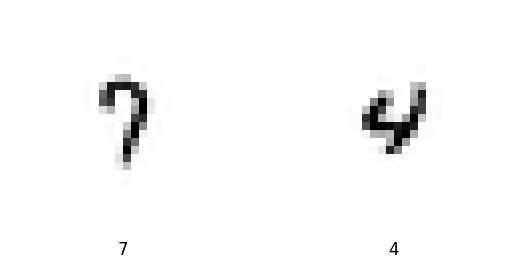

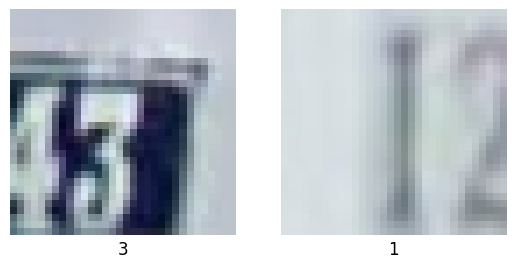

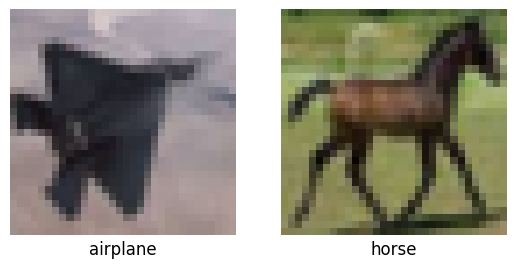

In [42]:
np.random.seed(43)

mnist_examples = [(ex['pixels'].numpy(), ex['label'].numpy()) for ds in EMNIST_EXAMPLE_DATA.values() for ex in iter(ds)]
mnist_examples = [mnist_examples[i] for i in np.random.choice(range(len(mnist_examples)), size=2, replace=False)]
plot_examples_of_ds(mnist_examples, label_map=list(range(10)))

svhn_examples = [(ex['image'].numpy(), ex['label'].numpy()) for ds in SVHN_EXAMPLE_DATA.values() for ex in iter(ds)]
svhn_examples = [svhn_examples[i] for i in np.random.choice(range(len(svhn_examples)), size=2, replace=False)]
plot_examples_of_ds(svhn_examples, label_map=list(range(10)))

cifar_examples = [(ex['image'].numpy(), ex['label'].numpy()) for ds in CIFAR10_EXAMPLE_DATA.values() for ex in iter(ds)]
cifar_examples = [cifar_examples[i] for i in np.random.choice(range(len(cifar_examples)), size=2, replace=False)]
plot_examples_of_ds(cifar_examples, label_map=CIFAR10_LABEL_NAMES)

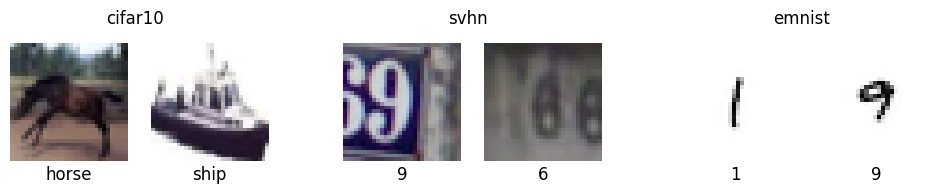

In [233]:
client_examples = {
    'cifar10': {k: list(map(lambda x: (x['image'], x['label'].numpy()), v)) for k, v in CIFAR10_EXAMPLE_DATA.items()},
    'svhn': {k: list(map(lambda x: (x['image'], x['label'].numpy()), v)) for k, v in SVHN_EXAMPLE_DATA.items()},
    'emnist' : {k: list(map(lambda x: (x['pixels'], x['label'].numpy()), v)) for k, v in EMNIST_EXAMPLE_DATA.items()},
}
plot_examples(ds_examples=client_examples, examples_per_ds=2, seed=42)

# Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GroupNormalization, Resizing
)
from tensorflow.keras.utils import plot_model

model = Sequential([
    Input((28,28,1)),
    Rescaling(1.),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax'),
])
# plot_model(model, show_layer_names=False)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                                

# EMNIST

In [9]:
EMNIST_TRAIN, EMNIST_TEST = tff.simulation.datasets.emnist.load_data()
EMNIST_CLIENT_IDS = sample_clients(EMNIST_TRAIN.client_ids, 4, seed=42)
EMNIST_EXAMPLE_DATA = {c: EMNIST_TRAIN.create_tf_dataset_for_client(c) for c in EMNIST_CLIENT_IDS}

# SVHN

In [10]:
def load_svhn(svhn_dir: str):
    svhn_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(svhn_dir) / 'train.sqlite'), element_spec=svhn_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(svhn_dir) / 'test.sqlite'), element_spec=svhn_spec, split_name=None)
    return train_client_data, test_client_data

In [11]:
SVHN_TRAIN, SVHN_TEST = load_svhn("/home/ole/masterarbeit/flidp/dataset-cache/svhn_v2")
SVHN_CLIENT_IDS = sample_clients(SVHN_TRAIN.client_ids, 4, seed=42)
SVHN_EXAMPLE_DATA = {c: SVHN_TRAIN.create_tf_dataset_for_client(c) for c in SVHN_CLIENT_IDS}

# CIFAR10

In [12]:
def load_cifar10(dir: str):
    tensor_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(dir) / 'train.sqlite'), element_spec=tensor_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(dir) / 'test.sqlite'), element_spec=tensor_spec, split_name=None)
    return train_client_data, test_client_data

In [13]:
CIFAR10_TRAIN, CIFAR10_TEST = load_cifar10("/home/ole/masterarbeit/flidp/dataset-cache/cifar10")
CIFAR10_CLIENT_IDS = sample_clients(CIFAR10_TRAIN.client_ids, 4, seed=42)
CIFAR10_EXAMPLE_DATA = {c: CIFAR10_TRAIN.create_tf_dataset_for_client(c) for c in CIFAR10_CLIENT_IDS}

# Plots

/tmp/ipykernel_238350/1921789433.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


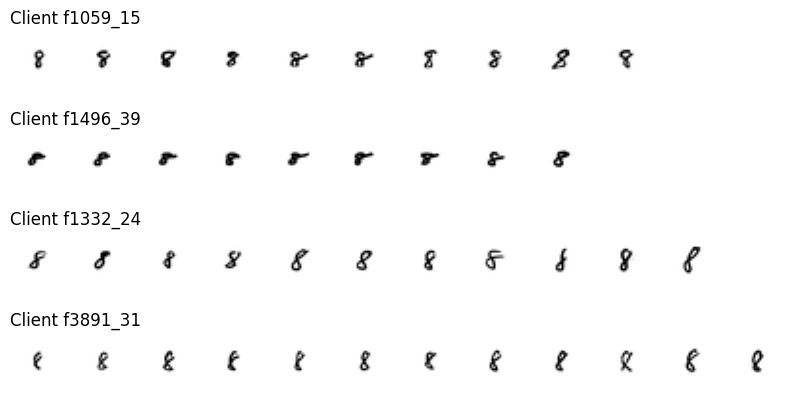

In [47]:
plot_mnist_examples(EMNIST_EXAMPLE_DATA, label=8)

/tmp/ipykernel_1463347/3264560748.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


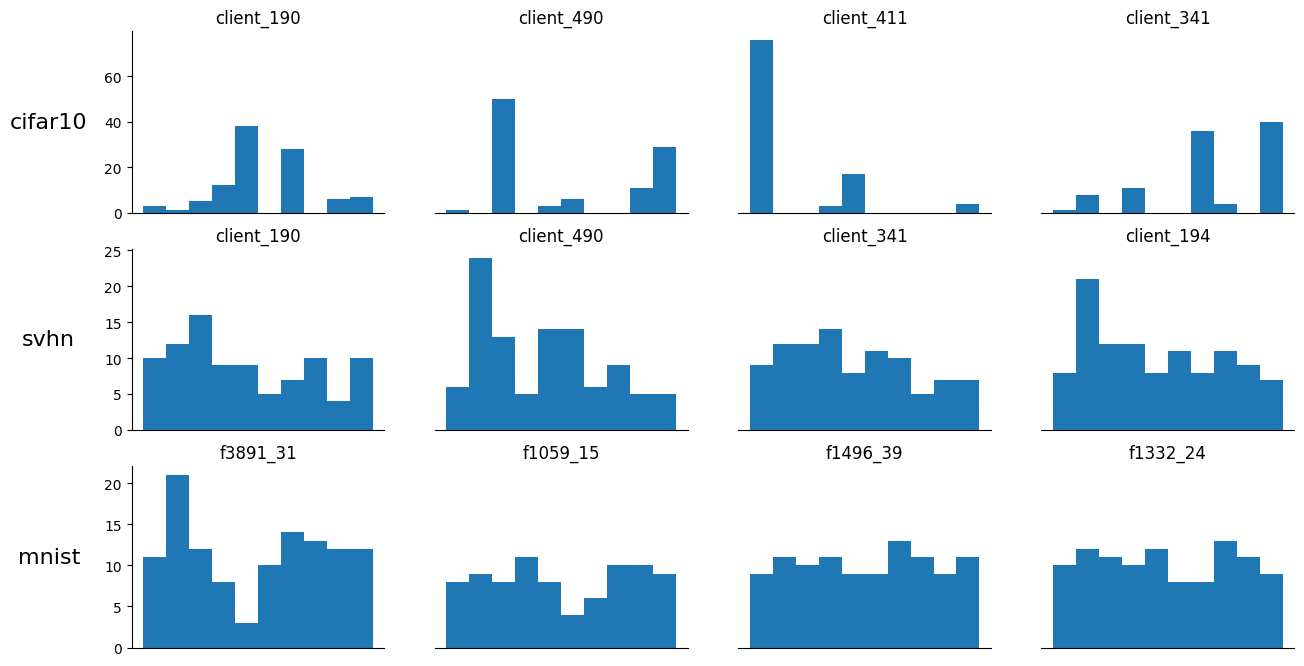

In [43]:
client_labels = {
    'cifar10': {k: list(map(lambda x: x['label'], v)) for k, v in CIFAR10_EXAMPLE_DATA.items()},
    'svhn': {k: list(map(lambda x: x['label'], v)) for k, v in SVHN_EXAMPLE_DATA.items()},
    'mnist' : {k: list(map(lambda x: x['label'], v)) for k, v in EMNIST_EXAMPLE_DATA.items()},
}
plot_label_distributions(client_labels)

In [46]:
EMNIST_TRAIN_LABELS = list(x['label'] for x in EMNIST_TRAIN.create_tf_dataset_from_all_clients().as_numpy_iterator())
SVHN_TRAIN_LABELS = list(x['label'] for x in SVHN_TRAIN.create_tf_dataset_from_all_clients().as_numpy_iterator())
CIFAR10_TRAIN_LABELS = list(x['label'] for x in CIFAR10_TRAIN.create_tf_dataset_from_all_clients().as_numpy_iterator())

In [68]:
def plot_all_label_dist(ds_labels, label_map):
    fontsize = 17
    label_counts = {i: len(list(filter(lambda x: x == i, ds_labels))) for i in set(ds_labels)}
    plt.bar(x=label_counts.keys(), height=label_counts.values())
    plt.xticks([label_map[i] for i in label_counts.keys()], fontsize=fontsize)
    plt.ylabel("number of examples", fontsize=fontsize)
    plt.xlabel("label", fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.show()

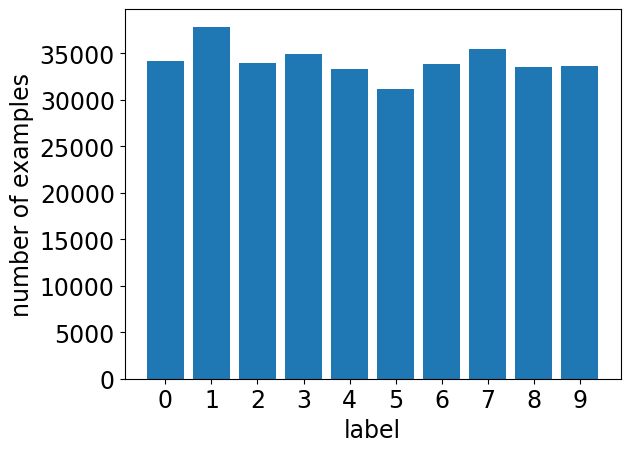

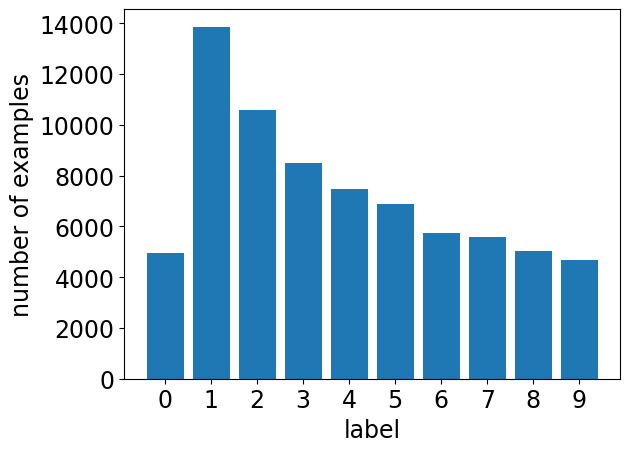

ConversionError: Failed to convert value(s) to axis units: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

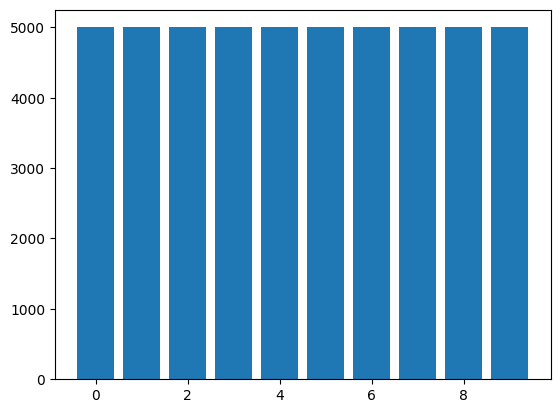

In [69]:
plot_all_label_dist(EMNIST_TRAIN_LABELS, label_map=list(range(10)))
plot_all_label_dist(SVHN_TRAIN_LABELS, label_map=list(range(10)))
plot_all_label_dist(CIFAR10_TRAIN_LABELS, label_map=CIFAR10_LABEL_NAMES)